# Quick Tour of BastionLab

## Why BastionLab?
Data owners often need or wish that remote data scientists would access their datasets - like a hospital might want to valorize their data to external parties, startups, labs, or receive help from external experts, for instance. 
The problem is that the most popular solution is to give access to a Jupyter Python notebook installed on the data owner infrastructure. 


![](https://github.com/mithril-security/bastionlab/raw/master/docs/assets/current_solution.png)

This is dangerous, because it exposes the dataset to serious data leakages. Jupyter was not made for this task and exfiltrating data can easily be done.
That is why we have built BastionLab, a data science framework to perform remote and secure Exploratory Data Analysis. Data scientists can remotely run queries on data frames without seeing the original data or intermediary results - according to the strict privacy policies defined by the data owner.


![](https://github.com/mithril-security/bastionlab/raw/master/docs/assets/proposed_solution.png)

BastionLab features include:
- Showing only aggregated results to maintain privacy with a minimal sample size to ensure the anonymization of each individual
- When case rows have to be displayed, only a minimal amount of information is shown, and all data shared is recorded and tracked. 

Differential Privacy will be integrated transparently in the future.

Technically, the framework uses polars (a Rust equivalent of pandas) lazy API to construct the queries locally. Once built, the queries are sent to the remote server of BastionLab and executed, if they pass the privacy policy rules defined by the data owner. BastionLab supports most data wrangling operations, like selects, groupbys, joins…

## Tutorial’s Introduction

In the following notebook tutorial, we will show you how to install BastionLab and use a few basic functionalities. We’ll use a mock example in which the data owner puts a Titanic passengers dataset at the disposal of the data scientist. 

“Titanic - Machine Learning from Disaster” dataset can be found on Kaggle and downloaded with a free user account https://www.kaggle.com/competitions/titanic/data.

Alternatively you can use the cell below:

In [ ]:
!wget 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'

This notebook is divided into three parts:
- Installation of BastionLab Client and Server
- The Data Owner's Side
- The Data Scientist's Side


By the end, the data scientist will be able to do Exploratory Data Analysis remotely, under the constraints defined by the data owner.


### Technical Requirements

To start this tutorial, ensure the following are already installed in your system:
- Python3.7 or greater (get the latest version of Python at https://www.python.org/downloads/ or with your operating system’s package manager)
- [Python Pip](https://pypi.org/project/pip/) (PyPi), the package manager
- [Docker](https://www.docker.com/) 

*Here's the [Docker official tutorial](https://docker-curriculum.com/) to set it up on your computer.*


## Installing BastionLab Client

We provide a pip package for our client library that contains all the necessary to interect with the BastionLab server. It provides high level abstraction such as remote objects which mimic the behavior of plain local objects. These objects actually are references to remote resources and allow running remote computations seemlessly in a secure fashion.

In [ ]:
!pip install bastionlab

# Installing BastionLab Server

BastionLab server has been packaged as a Docker image for increased portability. The image can be downloaded from DockerHub.

In [ ]:
!docker pull mithrilsecuritysas/bastionlab:latest

*You may alternatively install BastionLab Client or Server from source, refer to our more detailed [Installation Tutorial](docs/).*

## Running BastionLab Server

The docker image exposes port `50056` for gRPC communication with clients and uses a default configuration (no authentication, default settings).
For the purpose of this Tour, these settings are sufficient and we won't change them.

To run the server, we start a container using the downloaded image and we bind port `50056` to the same port on the host system.

In [ ]:
!docker run -it -p 50056:50056 --env DISABLE_AUTHENTICATION=1 mithrilsecuritysas/bastionlab:latest

# Data Owner's Side

In this Tour, we assume the Data Owner has a private dataset they want to explore. As they don't have the expertise, they would like to hire a Data Scientist and to give them a restricted access to their private data.

To keep this Tour short and simple, we will use weak but reasonable guarantees. If you're interested in setting up stricter policies, you are encouraged to have a look at our [Privacy policy tutorial](docs/).

BastionLab already ensures that the original dataset cannot be downloaded by the Data Scientist. In addition to that, we will set up a policy that logs all non privacy-preserving request so that the Data Owner can take adequate actions.

This section is devided in three steps:
- load the dataset
- establish a connection
- send the data and set a custom policy

### Upload the data frame to the BastionLab Client

We first load the Titanic dataset we downloaded at the beginning of the Tour in memory as a DataFrame object:

In [5]:
import polars as pl

df = pl.read_csv("titanic.csv")

We then open a connection to the server by providing its hostname.

In [6]:
from bastionlab import Connection

connection = Connection("localhost")

Using BastionLab client, we'll upload our data to the server in a secure and private way. To do so, we need to define a custom privacy policy that will require two parameters.

- A `safe_zone` which is a condition any request must meet to be considered privacy-preserving.
- An `unsafe_handling` which is the action taken in case a request violates the `safe_zone`.

For the purpose of this tutorial, we'll use the following:
- Any request that aggregates at least 10 rows of the original DataFrame is safe,
- We decide to log any offending request on the server side, so the Data Owner can see it.

To send the DataFrame with the privacy policy to the server, we'll use the `send_df()` method of the `polars` interface of the client. We'll pass it our custom policy and a list of columns to be sanitized (i.e. set to null) if retrieved by the Data Scientist.

In [7]:
from bastionlab.polars.policy import Policy, Aggregation, Log

policy = Policy(safe_zone=Aggregation(min_agg_size=10), unsafe_handling=Log())
connection.client.polars.send_df(df, policy=policy, sanitized_columns=["Name"])

FetchableLazyFrame(identifier=b61ad8aa-db48-4fbc-b57a-5604d5cf1f37)

The server returns a FetchableLazyFrame which is a reference to the remote DataFrame. It can be used as if it were locally available. We'll see how to use it in the Data Scientist's side section.

## Data Scientist’s Side
In this part, we’ll show how the data scientist can access the Data Owner’s dataset, run queries, fetch the results, and display them.

This tutorial is divided into five steps:
- Access the data owner’s dataset
- Run queries
- Fetching the results
- Data visualization functions

### Access the Data Owner’s Dataset 

The core object of BastionLab's polars API is the `RemoteLazyFrame` which is a reference to the DataFrame uploaded by the data owner, along with some metadata such as the names and types of the columns. `RemoteLazyFrame`s can often be used as if they were plain polars `LazyFrames`. In particular, almost all the functions available in the Python API of polars can be used with `RemoteLazyFrame`s to run computations on the server.

One major difference is that data must be downloaded prior to any local usage such as printing or plotting. Because our API is inherently lazy, not all `RemoteLazyFrames` can be downloaded. In particular, it wouldn't make sense to download a result that hasn't been computed yet on the server. Only `FetchableLazyFrame`s, a subtype of `RemoteLazyFrame` can be downloaded with their specific `fetch()` method. As it's the case with polars' `LazyFrame`s, the user must first call the `collect()` method to run the computation and to get a `FetchableLazyFrame` as a result. In practice, this means that most calls to `collect()` with `polars` will be replaced by `collect().fetch()` with `bastionai.polars` 

As we do not know the unique identifier of the DataFrame uploaded by the data owner, we start by asking the server to list all available DataFrames.

In [8]:
connection = Connection("localhost", 50056)

client = connection.client

all_rdfs = client.polars.list_dfs()

rdf = all_rdfs[0]

all_rdfs

[FetchableLazyFrame(identifier=b61ad8aa-db48-4fbc-b57a-5604d5cf1f37)]

The server returns a list of `FetchableLazyFrame`s that we can inspect. In our case, we can just take the first one as the data owner has only uploaded one DataFrame so far.

### Running Queries

Now that we have a `RemoteLazyFrame` corresponding to the data owner’s DataFrame, it is time to run some queries on it.

To define these queries, we can directly use all the methods provided by polars’ lazy API. Here, the adjective lazy means that no computation will be run unless explicitly needed. This allows the data scientist to build queries with a Pythonic approach from the RemoteLazyFrame, and when an operation needs to be executed on the data, the query is serialized and sent to the server. 

The `collect()` method triggers the execution of all the recorded operations on the server.


In [9]:
rdf1 = rdf.head(5)
print(rdf1)

rdf2 = rdf1.collect()
print(rdf2)

RemoteLazyFrame
FetchableLazyFrame(identifier=a78826e5-69ba-41e7-9ef4-88349935e2c7)


In this example, the first line returns a new RemoteLazyFrame that records the head operation - nothing happens on the server. In the second line, however, the call to collect()  sends a query to the server instructing it to do a head operation, and will run it right away.


What is key to understanding, is that **every call to collect() will create a new DataFame** on the server side that contains the result.

On the client side, **collect() returns a new FetchableLazyFrame** that references the result on the server.

### Fetching Results

At some point in your process, you will need to download the results to use them locally or to display them. This can be achieved with the fetch method.

The fetch method is defined on the FetchableLazyFrame class which extends the RemoteLazyFrame class. 

Recall that we’ve already seen the two ways of getting FetchableLazyFrames: by listing available DataFrames on the server, and by calling collect() on any RemoteLazyFrame. 
In practice, this means that fetch() may only be called on references to DataFrames already available on the server or after a call to collect(). As no computation has run before you call collect(), it wouldn’t actually make sense to fetch() the result because it does not yet exist! 


In [10]:
rdf.head(5).collect().fetch()

Reason: Only 1 subrules matched but at least 2 are required.
Failed sub rules are:
Rule #1: Cannot fetch a DataFrame that does not aggregate at least 10 rows of the initial dataframe uploaded by the data owner.

This incident will be reported to the data owner.


PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
i64,i64,i64,str,str,f64,i64,i64,str,f64,str,str
1,0,3,null,"""male""",22.0,1,0,"""A/5 21171""",7.25,null,"""S"""
2,1,1,null,"""female""",38.0,1,0,"""PC 17599""",71.2833,"""C85""","""C"""
3,1,3,null,"""female""",26.0,0,0,"""STON/O2. 31012...",7.925,null,"""S"""
4,1,1,null,"""female""",35.0,1,0,"""113803""",53.1,"""C123""","""S"""
5,0,3,null,"""male""",35.0,0,0,"""373450""",8.05,null,"""S"""


In addition, `fetch()` downloads the resulting DataFrame after performing some checks on how it was obtained and what the data owner authorizes in their policy. These checks allow BastionLab to uphold a decent level of privacy without too big an impact on your workflow.

Recall that the Data Owner has set the following policy:
- a `safe_zone` that accepts queries aggregating at least 10 original rows,
- the `Log` `unsafe_hanling` action which prints a message in the server logs in case of a violation of the `safe_zone`.

As printing the first rows of a DataFrame is not an aggregation, we are actually violating the safe zone which explains the printed warning message. The same message is also recorded in the logs of the server.

Also note that the *Name* column has been filled with `null` values as it was added to the `sanitized_columns` list by the Data Owner.


Let’s now try a more involved query: we compute the survival rates of the passengers on the Titanic based on their ticket class.

In [11]:
per_class_rates = (
    rdf.select([pl.col("Pclass"), pl.col("Survived")])
    .groupby(pl.col("Pclass"))
    .agg(pl.col("Survived").mean())
    .sort("Survived", reverse=True)
    .collect()
    .fetch()
)
per_class_rates

Pclass,Survived
i64,f64
1,0.62963
2,0.472826
3,0.242363


Once again, we must use:
- collect() to run the computation on the server
- fetch() to retrieve the result locally 

In this case, no message appears because the query involves an aggregation step.

### Data Visualization Functions

The data scientist can also use plotting functions to visualize data while still upholding data privacy.

Although plots are computed locally, the client only retrieves the necessary data and the policy guranties still hold.

#### Histograms

Histograms (and barplots) inherently aggregate data which makes them a good fit for private data exploration.
Instead of fetching the whole DataFrame, BastionLab client selects relevant rows, runs an aggregation query on the server and fetches the aggregated data.

In the following example, we plot the number of passengers who survived per age class. We set a bin size of 10 which means our age classes span 10 years.

Reason: Only 1 subrules matched but at least 2 are required.
Failed sub rules are:
Rule #1: Cannot fetch a DataFrame that does not aggregate at least 10 rows of the initial dataframe uploaded by the data owner.

This incident will be reported to the data owner.


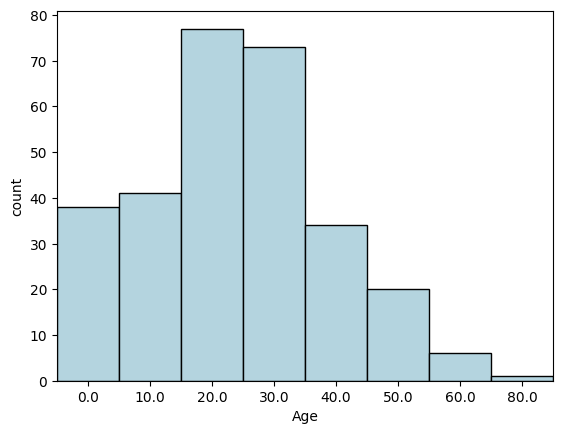

In [12]:
rdf.filter(pl.col("Survived") == 1).histplot(x="Age", bins=10)

We get a warning message because there are outliers in our data: people aged 70 or more are few. They form groups that are smaller than 10 in size and, so, they violate the Data Owner's policy.
In practice, outlier data are more vulnerable to deanonymization attacks because they make correlations easier to find. It is standard practice in privacy to remove outlier data to mitigate this risk.

One solution to make our example more-privacy preserving is to clip the age column to remove outliers prior to making the barplot.

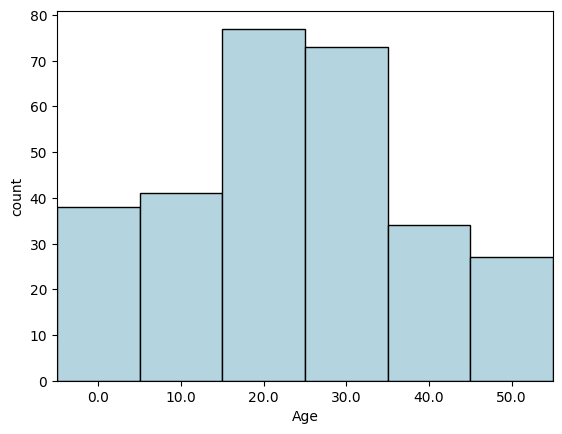

In [13]:
(
    rdf.select([pl.col("Survived"), pl.col("Age").clip(0, 50)])
    .filter(pl.col("Survived") == 1)
    .histplot(x="Age", bins=10)
)

In this case, outliers are counted in a new 50+ bin, and each bin aggregates at least 10 passengers. The query does not violate the safe zone anymore.

#### Curve and scatter plots

BastionLab also features other types of plots although these are less suited for privacy-preserving exploration.
They typically require fetching the whole DataFrame because they do not naturally involve an aggregation step like histograms do.

Bellow are two examples of the same relationship between age, fare and survival as a curve plot and as a scatter plot.

Reason: Only 1 subrules matched but at least 2 are required.
Failed sub rules are:
Rule #1: Cannot fetch a DataFrame that does not aggregate at least 10 rows of the initial dataframe uploaded by the data owner.

This incident will be reported to the data owner.


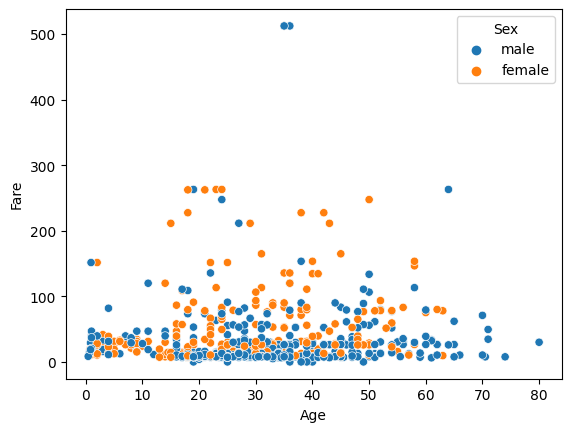

In [14]:
rdf.scatterplot(x="Age", y="Fare", hue="Sex")

Reason: Only 1 subrules matched but at least 2 are required.
Failed sub rules are:
Rule #1: Cannot fetch a DataFrame that does not aggregate at least 10 rows of the initial dataframe uploaded by the data owner.

This incident will be reported to the data owner.


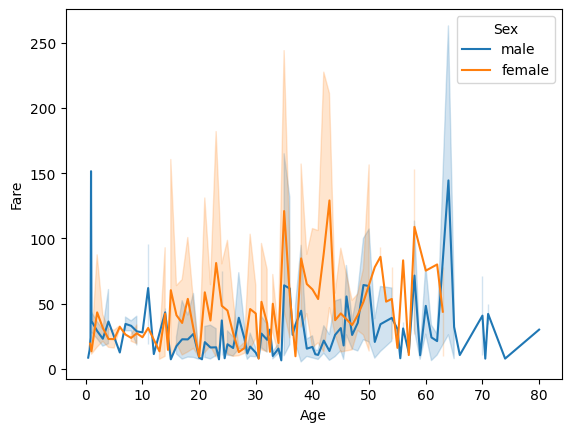

In [16]:
rdf.lineplot(x="Age", y="Fare", hue="Sex")

For more information on these functions and more complex examples, check out our data visualization tutorial [here](../tutorials/visualization.ipynb).